In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np


import tensorflow as tf
import pydicom

import glob
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
BASE_DIR = "./Data"
DATA_DIR = os.path.join(BASE_DIR,"2d_lung_opacity_challenge/")
classes = pd.read_csv(glob.glob(os.path.join(DATA_DIR,"*.csv"))[0])
target = pd.read_csv(glob.glob(os.path.join(DATA_DIR,"*.csv"))[1])

In [5]:
train_labels = pd.merge(classes, target[["patientId","Target"]], on = "patientId", how="left")

In [6]:
assert train_labels.drop_duplicates().shape == train_labels.drop_duplicates('patientId').shape

train_labels = train_labels.drop_duplicates().reset_index(drop = True)

In [7]:
print(train_labels.groupby(['class', 'Target']).size().reset_index(name='Patient Count').to_markdown())

|    | class                        |   Target |   Patient Count |
|---:|:-----------------------------|---------:|----------------:|
|  0 | Lung Opacity                 |        1 |            6012 |
|  1 | No Lung Opacity / Not Normal |        0 |           11821 |
|  2 | Normal                       |        0 |            8851 |


In [8]:
def draw(input_ids):
    # A maximum of 3 images in a row
    ncols, nrows = min(3,len(input_ids)), len(input_ids)//min(3,len(input_ids)) +1 if len(input_ids)%min(3,len(input_ids)) !=0 else len(input_ids)//min(3,len(input_ids))
    # figure size, inches
    figsize = [10, 8]     

    # create figure (fig), and array of axes (ax)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # plot image for single sub-plot
    for i, axi in enumerate(ax.flat):
        try:
            dicom_path = input_ids[i]
            data = pydicom.read_file(dicom_path)
            # one can also use plt.cm.bone
            axi.imshow(data.pixel_array, cmap="gray")
            # get indices of row/column
            rowid = i // ncols
            colid = i % ncols
        except IndexError as e:
            continue

    # For some of you who want to add bounding box info to plots as
    # well can access by row-id and col-id on the array of axes
    # ax[row-id][col-id].plot()

    plt.tight_layout(True)
    plt.show()

In [9]:
np.random.seed(123)
examples_non_normal = np.random.choice(train_labels[train_labels["class"].\
                                                    isin(["No Lung Opacity / Not Normal"])].patientId,
                                      size = 3,
                                      replace = False)

examples_non_normal = [os.path.join(DATA_DIR,"Train",x+".dcm") for x in examples_non_normal]

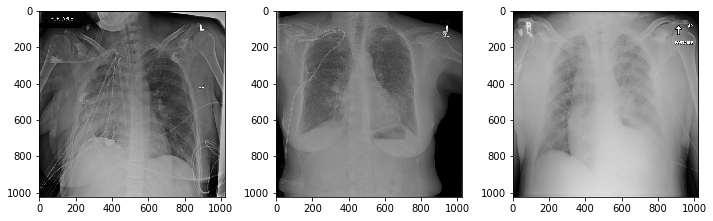

In [10]:
draw(examples_non_normal)

### DICOM Metadata

In [8]:
def get_metadata(patient_id):
    """
    Returns metadata from each dicom file
    """
    data = pydicom.read_file(os.path.join(DATA_DIR,"Train",patient_id+".dcm"), 
                             stop_before_pixels=False)
    _id = data.PatientID
    _age = data.PatientAge
    _sex = data.PatientSex
    # col_spacing (horizontal)
    _pixelspacing_x = data.PixelSpacing[1]
    # row_spacing (vertical)
    _pixelspacing_y = data.PixelSpacing[0]
    _viewpos = data.ViewPosition
    _mean = np.mean(data.pixel_array)
    _min = np.min(data.pixel_array)
    _max = np.max(data.pixel_array)
    return pd.DataFrame([[_id, _age, _sex, _pixelspacing_x, _pixelspacing_y, _viewpos ,_min, _max, _mean]],
                        columns = ["patientId","age","sex","pixel_spacing_x","pixel_spacing_y","view_pos",
                                  "min_pixint","max_pixint","mean_pixint"])

In [9]:
from joblib import Parallel, delayed, parallel_backend
from tqdm import tqdm
train_dicom = Parallel(n_jobs=os.cpu_count()-1, backend="threading")(delayed(get_metadata)(pt_id) for pt_id in tqdm(train_labels.patientId))

100%|███████████████████████████████████████████████████████████████████████████| 26684/26684 [04:25<00:00, 100.58it/s]


In [10]:
train_dicom_df = pd.concat(train_dicom, axis = 0)

In [11]:
train_dicom_df.to_csv("dicom_metadata.csv", index = None)

In [12]:
# Train Labels with Metadata
train_labels_w_md = pd.merge(train_labels, train_dicom_df, on = "patientId", how="left")

In [18]:
train_labels_w_md.to_pickle("./dicom_metadata.pkl")

In [16]:
import seaborn as sns
sns.set_style('whitegrid')

### View Position

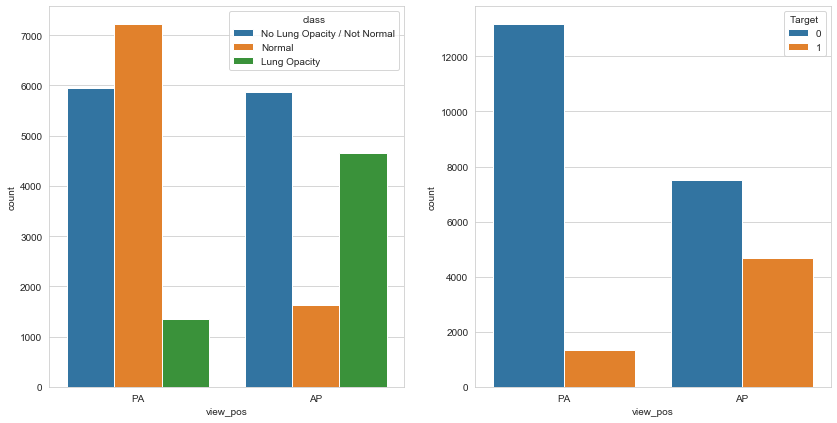

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
sns.countplot(x='view_pos', hue='class', data=train_labels_w_md, ax=axes[0])
sns.countplot(x='view_pos', hue='Target', data=train_labels_w_md, ax=axes[1])

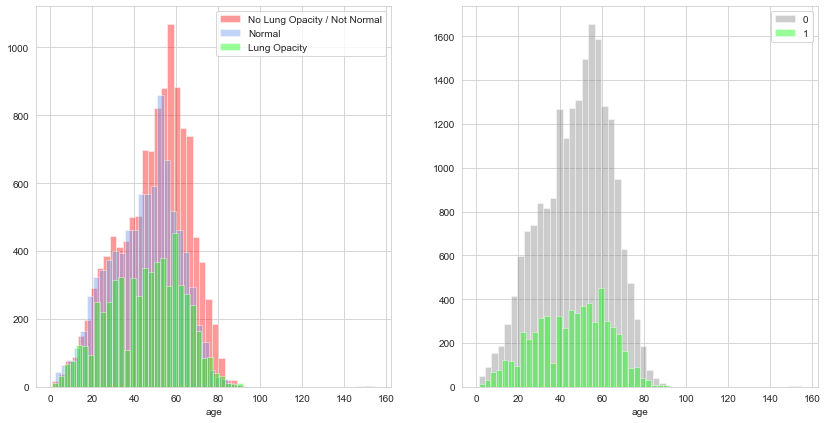

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(train_labels_w_md[train_labels_w_md['class']=='No Lung Opacity / Not Normal']['age'], 
                 hist=True, 
                 kde=False, 
                 color='red', 
                 label='No Lung Opacity / Not Normal', ax=axes[0])
p = sns.distplot(train_labels_w_md[train_labels_w_md['class']=='Normal']['age'], 
                 hist=True, 
                 kde=False, 
                 color='cornflowerblue', 
                 label='Normal', ax=axes[0])
p = sns.distplot(train_labels_w_md[train_labels_w_md['class']=='Lung Opacity']['age'], 
                 hist=True, 
                 kde=False, 
                 color='lime', 
                 label='Lung Opacity', ax=axes[0])
_ = p.legend()

p = sns.distplot(train_labels_w_md[train_labels_w_md['Target']==0]['age'], 
                 hist=True, 
                 kde=False, 
                 color='gray', 
                 label='0', ax=axes[1])
p = sns.distplot(train_labels_w_md[train_labels_w_md['Target']==1]['age'], 
                 hist=True, 
                 kde=False, 
                 color='lime', 
                 label='1', ax=axes[1])
_ = p.legend()

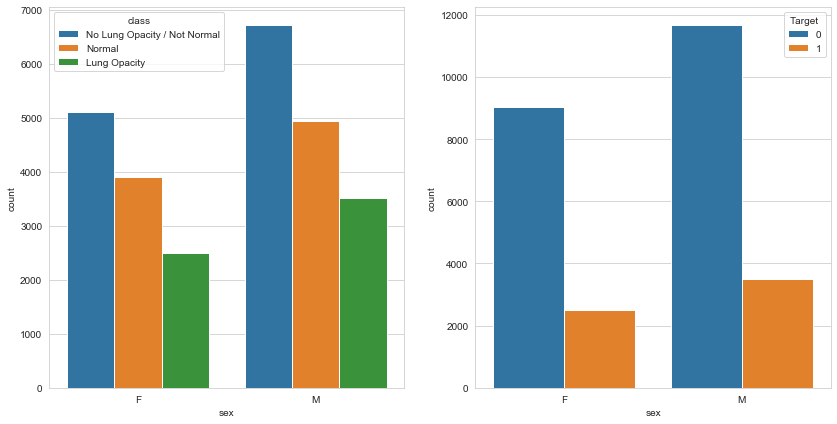

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
sns.countplot(x='sex', hue='class', data=train_labels_w_md, ax=axes[0])
sns.countplot(x='sex', hue='Target', data=train_labels_w_md, ax=axes[1])

In [21]:
train_labels_w_md["age"] = train_labels_w_md.age.apply(lambda x:int(x))

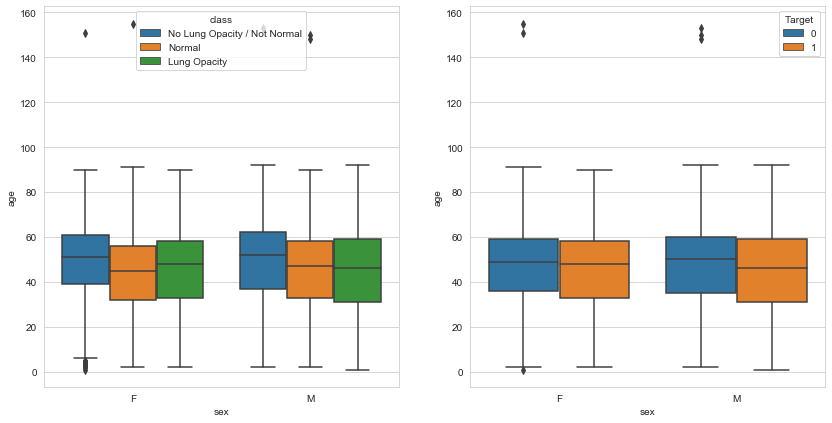

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
sns.boxplot(x='sex', y = 'age', hue='class', data=train_labels_w_md, ax=axes[0])
sns.boxplot(x='sex', y = 'age', hue='Target', data=train_labels_w_md, ax=axes[1])

In [23]:
train_labels_w_md["pixel_spacing_x_norm"] = train_labels_w_md.pixel_spacing_x.apply(lambda x: round(float(x),2))
train_labels_w_md["pixel_spacing_y_norm"] = train_labels_w_md.pixel_spacing_y.apply(lambda x: round(float(x),2))

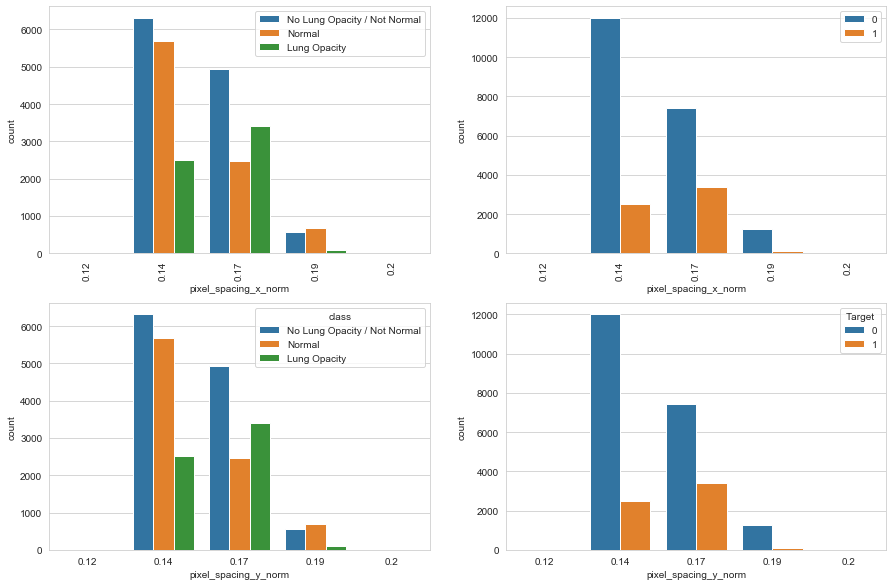

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plot = sns.countplot(x='pixel_spacing_x_norm', hue='class', data=train_labels_w_md, ax=axes[0][0])
plot.set_xticklabels([x for x in plot.get_xticklabels()],rotation=90)
plot.legend(loc='upper right')
plot = sns.countplot(x='pixel_spacing_x_norm', hue='Target', data=train_labels_w_md, ax=axes[0][1])
plot.set_xticklabels([x for x in plot.get_xticklabels()],rotation=90)
plot.legend(loc='upper right')

sns.countplot(x='pixel_spacing_y_norm', hue='class', data=train_labels_w_md, ax=axes[1][0])
plot.set_xticklabels([x for x in plot.get_xticklabels()],rotation=90)
plot.legend(loc='upper right')
sns.countplot(x='pixel_spacing_y_norm', hue='Target', data=train_labels_w_md, ax=axes[1][1])
plot.set_xticklabels([x for x in plot.get_xticklabels()],rotation=90)
plot.legend(loc='upper right')

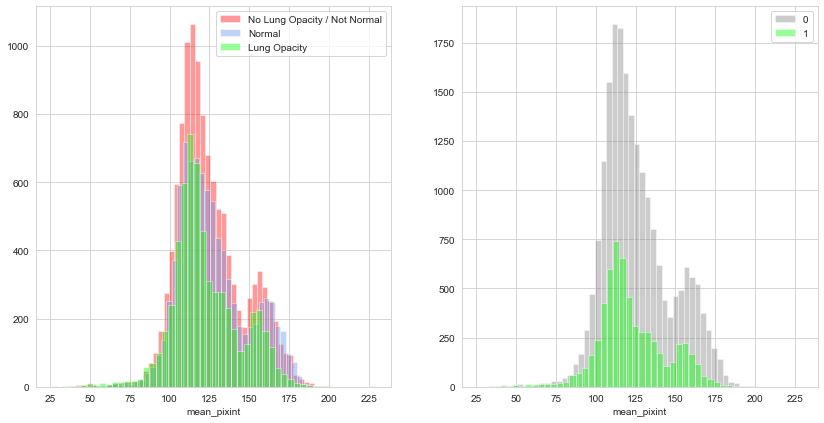

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(train_labels_w_md[train_labels_w_md['class']=='No Lung Opacity / Not Normal']['mean_pixint'], 
                 hist=True, 
                 kde=False, 
                 color='red', 
                 label='No Lung Opacity / Not Normal', ax=axes[0])
p = sns.distplot(train_labels_w_md[train_labels_w_md['class']=='Normal']['mean_pixint'], 
                 hist=True, 
                 kde=False, 
                 color='cornflowerblue', 
                 label='Normal', ax=axes[0])
p = sns.distplot(train_labels_w_md[train_labels_w_md['class']=='Lung Opacity']['mean_pixint'], 
                 hist=True, 
                 kde=False, 
                 color='lime', 
                 label='Lung Opacity', ax=axes[0])
_ = p.legend()

p = sns.distplot(train_labels_w_md[train_labels_w_md['Target']==0]['mean_pixint'], 
                 hist=True, 
                 kde=False, 
                 color='gray', 
                 label='0', ax=axes[1])
p = sns.distplot(train_labels_w_md[train_labels_w_md['Target']==1]['mean_pixint'], 
                 hist=True, 
                 kde=False, 
                 color='lime', 
                 label='1', ax=axes[1])
_ = p.legend()

In [5]:
import cv2
import scipy
import pandas as pd
train_labels_w_md = pd.read_pickle("./dicom_metadata.pkl")

In [6]:
def histogram_equalization(img, clip_limit, grid_size):
    """
    Histogram Equalization
    """
    clahe = cv2.createCLAHE(clipLimit = clip_limit, 
                            tileGridSize = grid_size)
    img_clahe = clahe.apply(img)
    
    return img_clahe
    

In [7]:
def resample(img, x_pixel, y_pixel):
    new_size = [1, 1]
    
    size = np.array([x_pixel, y_pixel])
    
    img_shape = np.array(img.shape)
    
    new_shape = img_shape * size
    new_shape = np.round(new_shape)
    resize_factor = new_shape / img_shape
    
    resampled_img = scipy.ndimage.interpolation.zoom(img, resize_factor)
    
    return resampled_img

In [8]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Dropout,
    MaxPooling2D,
    concatenate,
    BatchNormalization,
    Flatten,
    Dense
)
from tensorflow.keras.optimizers import Adam

METRICS = [
      tf.keras.metrics.AUC(name='auc'),
]

In [9]:
def convolution_block(input_layer, num_filters, kernel_size,
                      strides, padding = 'valid',
                      activation = 'selu', 
                      batch_normalization = False,
                      pool_kernel = None, dropout_rate = None):
    
    layer = Conv2D(num_filters, kernel_size, strides = strides, 
                   padding=padding, activation=activation)(input_layer)
    if batch_normalization:
        layer = BatchNormalization()(layer)
    if pool_kernel:
        layer = MaxPooling2D(pool_kernel)(layer)
    if dropout_rate:
        layer = Dropout(dropout_rate)(layer)
    return layer

In [10]:
bin_labels = ['0_20', '20_40', '40_60', '60_80', '80_plus']
train_labels_w_md['age_bucketed'] = pd.cut(train_labels_w_md['age'].astype(int),
                              bins = [0, 20, 40, 60, 80, max(train_labels_w_md['age'].astype(int))],
                              labels = bin_labels)

In [11]:
from sklearn.preprocessing import LabelBinarizer

age_binarizer = LabelBinarizer()
age_binarizer.fit(train_labels_w_md['age_bucketed'])
transformed_age = age_binarizer.transform(train_labels_w_md['age_bucketed'])
transformed_age_ohe = pd.DataFrame(transformed_age)
transformed_age_ohe.columns = ["age_bin_trans_"+str(i) for i in range(len(age_binarizer.classes_))]

view_pos_binarizer = LabelBinarizer()
view_pos_binarizer.fit(train_labels_w_md['view_pos'])
transformed_view_pos = view_pos_binarizer.transform(train_labels_w_md['view_pos'])
transformed_view_pos_ohe = pd.DataFrame(transformed_view_pos)
transformed_view_pos_ohe.columns = ["view_pos_trans"]


data = pd.concat([train_labels_w_md, transformed_age_ohe, transformed_view_pos_ohe], axis=1)

In [12]:
def get_train_images(dicom_path, target_shape):
    img = pydicom.read_file(dicom_path)
    img_equalized = histogram_equalization(img.pixel_array, 4, (8,8))
    img_isotropic = resample(img.pixel_array, img.PixelSpacing[1], img.PixelSpacing[0])
    img_standardized = cv2.resize(img_isotropic, target_shape, interpolation = cv2.INTER_CUBIC)
    # Pixel Standardization
    img_standardized = np.array(img_standardized)/255
    res = np.expand_dims(img_standardized, axis = 2)
    return res

In [13]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(data,test_size=0.25, random_state=42)

In [14]:
TARGET_SHAPE = (224,224)
BATCH_SIZE = 32

In [15]:
def get_data_generator(df, target_shape, shuffle = True, batch_size=32):
    """
    Generator function which yields the input data and output for different clusters
    """
    img, feat_set, y = [], [], []
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    
    while True:
        for i,row in df.iterrows():
            feat_set.append(np.array(row[[x for x in df.columns if "_trans" in x]].tolist()))
            img.append(get_train_images(os.path.join(DATA_DIR,"Train",row['patientId'] + ".dcm"),
                                        TARGET_SHAPE))
            y.append(np.array([row['Target']]))
            
            if len(feat_set) >= batch_size:
                yield (np.array(img), np.array(feat_set)), y                
                img, feat_set, y = [], [], []

In [31]:
def build_model():
    input_img = Input(TARGET_SHAPE+(1,))
    input_feats = Input((6,))
    cb1 = convolution_block(input_img, num_filters = 128, kernel_size = 8,
                      strides = 1, padding = 'valid',
                      batch_normalization = True,
                      activation = 'relu', 
                      pool_kernel = None, dropout_rate = None)
    cb2 = convolution_block(cb1, num_filters = 64, kernel_size = 4,
                      strides = 1, padding = 'valid',
                      activation = 'relu', 
                      pool_kernel = 2, dropout_rate = None)
    cb3 = convolution_block(cb2, num_filters = 32, kernel_size = 4,
                      strides = 1, padding = 'valid',
                      activation = 'relu', 
                      pool_kernel = 2, dropout_rate = 0.2)
    cb4 = convolution_block(cb3, num_filters = 8, kernel_size = 2,
                      strides = 1, padding = 'valid',
                      activation = 'relu', 
                      pool_kernel = 2, dropout_rate = 0.2)
    
    conv_flat = Flatten()(cb4)
    cl1 = Dense(128, activation='relu')(conv_flat)
    cl2 = Dense(64, activation='relu')(cl1)
    cl3 = Dense(32, activation='relu')(cl2)
    cl4 = Dense(16, activation='relu')(cl3)
    
    # Feature block
    fl1 = Dense(4, activation='relu')(input_feats)
    
    concat_layer = concatenate([cl4, fl1], axis = 1)
    
    # prediction block
    pl1 = Dense(16, activation = 'relu')(concat_layer)
    pl2 = Dense(8, activation = 'relu')(pl1)
    output = Dense(1, activation = 'sigmoid')(pl2)
    
    return Model([input_img, input_feats], output)

In [32]:
model = build_model()

model.compile(optimizer= 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [33]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 217, 217, 128 8320        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 217, 217, 128 512         conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 214, 214, 64) 131136      batch_normalization_3[0][0]      
____________________________________________________________________________________________

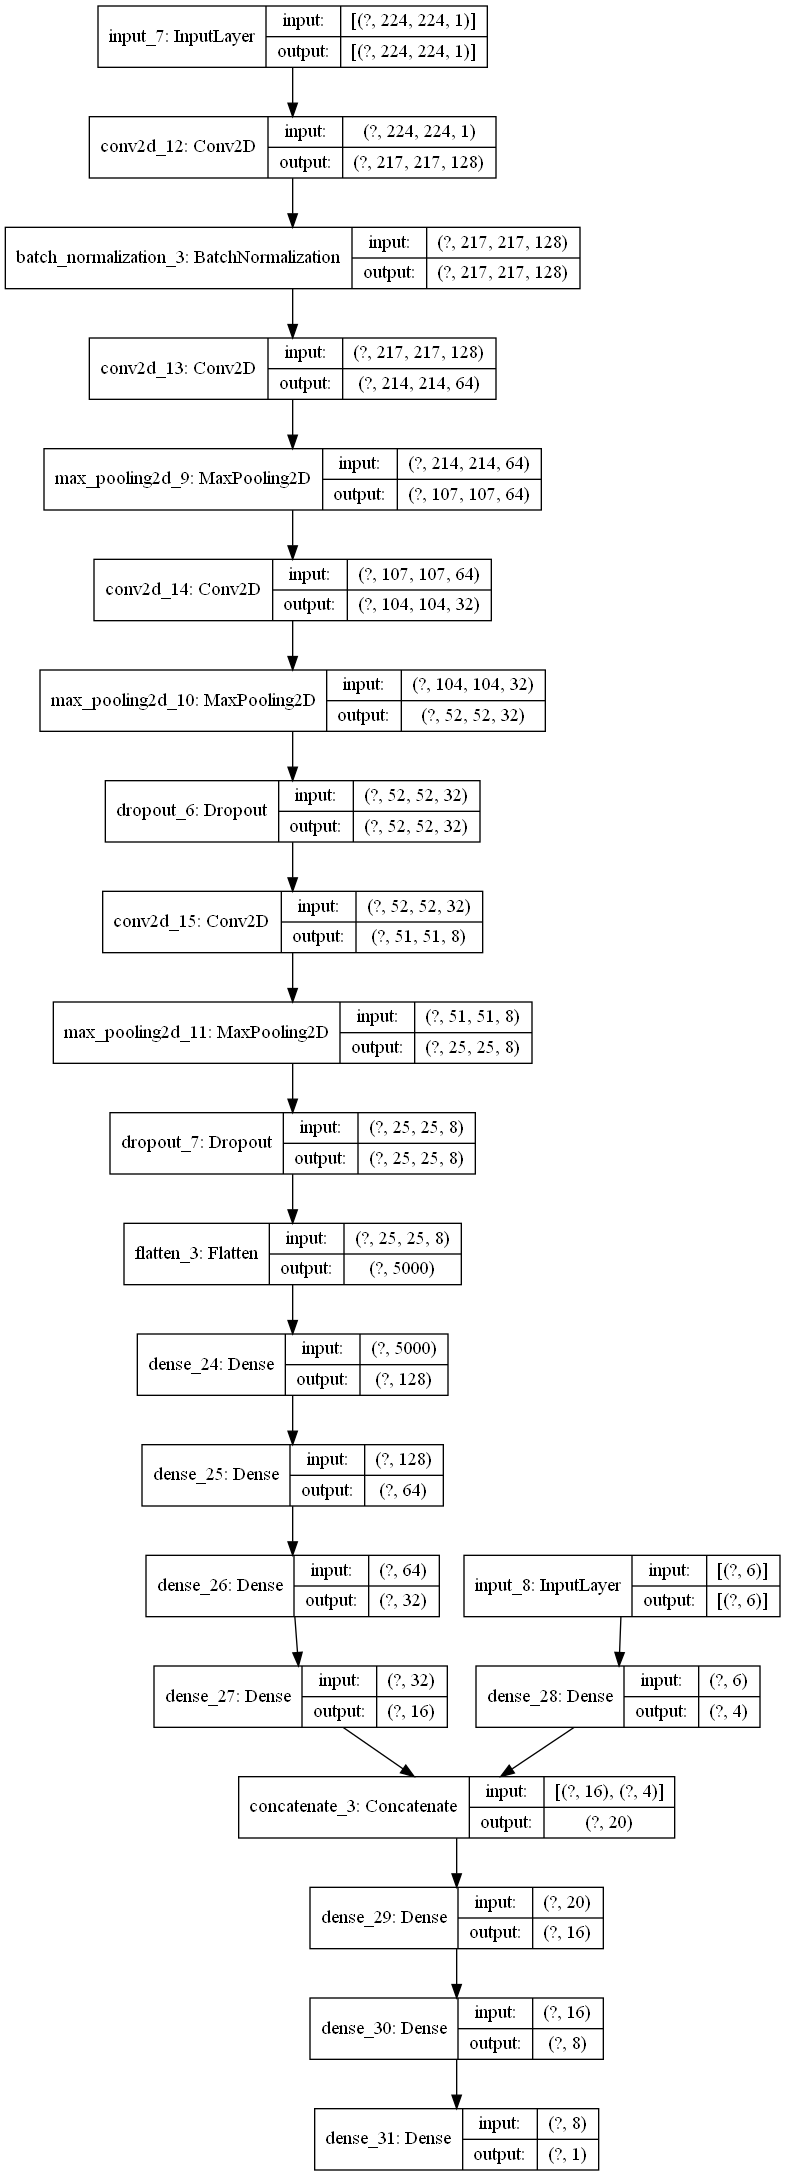

In [34]:
tf.keras.utils.plot_model(model,  show_shapes=True)

In [35]:
train_generator = get_data_generator(train, TARGET_SHAPE, True, BATCH_SIZE)
val_generator = get_data_generator(val, TARGET_SHAPE, True, BATCH_SIZE)

history = model.fit(train_generator,
                    steps_per_epoch= 10, #len(train)//BATCH_SIZE,
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps= 10) #len(val)//BATCH_SIZE)

Epoch 1/10
10/10 [==============================] - 50s 5s/step - loss: 0.7345 - auc: 0.4393 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 2/10
10/10 [==============================] - 54s 5s/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 3/10
10/10 [==============================] - 57s 6s/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 4/10
10/10 [==============================] - 64s 6s/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 68s 7s/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 6/10
10/10 [==============================] - 56s 6s/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 7/10
10/10 [==============================] - 59s 6s/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 8/10
10/10 [==============================] - 54s 5s/step - loss: 0.6931 - auc: 